NOTE: THIS NOTEBOOK TAKES A VERY LONG TIME TO RUN (APPROXIMATELY 2 HOURS ON A DELL XPS 13 WITH 8 GB RAM) AND DEPENDS ON 'aqi_augmented.csv' TO BE GENERATED FROM 'Create Master Data Source Regression.ipynb'

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import time
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, vstack 
import string

In [2]:
aqi_df = pd.read_csv('datasets/aqi_augmented.csv', index_col = 0)
aqi_df['DATE'] = pd.to_datetime(aqi_df['DATE'])
aqi_df.head()

KeyboardInterrupt: 

In [3]:
# first see how many nulls are in each column
print(aqi_df.shape)
pd.isnull(aqi_df).sum()/aqi_df.shape[0]

(7243237, 33)


STATE_NAME                         0.000000
COUNTY_CODE                        0.000000
DATE                               0.000000
AQI                                0.000000
FIRES_COUNT_COUNTY_0_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_0_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_0_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_0_WEEK_PRIOR      0.000000
FIRES_COUNT_COUNTY_1_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_1_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_1_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_1_WEEK_PRIOR      0.000000
FIRES_COUNT_COUNTY_2_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_2_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_2_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_2_WEEK_PRIOR      0.000000
AQI_1_PRIOR                        0.000000
AQI_2_PRIOR                        0.000000
AQI_3_PRIOR                        0.000000
AQI_1_DAY_OFFSET                   0.071659
AQI_2_DAY_OFFSET                   0.071612
AQI_3_DAY_OFFSET                   0.035406
AQI_4_DAY_OFFSET                

In [4]:
# all see how many zeros show up in each column
print(aqi_df.shape)
(aqi_df == 0).sum()/aqi_df.shape[0]

(7243237, 33)


STATE_NAME                         0.000000
COUNTY_CODE                        0.000000
DATE                               0.000000
AQI                                0.003814
FIRES_COUNT_COUNTY_0_WEEK_PRIOR    0.940195
FIRES_SIZE_COUNTY_0_WEEK_PRIOR     0.940195
FIRES_COUNT_STATE_0_WEEK_PRIOR     0.516777
FIRES_SIZE_STATE_0_WEEK_PRIOR      0.516777
FIRES_COUNT_COUNTY_1_WEEK_PRIOR    0.940163
FIRES_SIZE_COUNTY_1_WEEK_PRIOR     0.940163
FIRES_COUNT_STATE_1_WEEK_PRIOR     0.516736
FIRES_SIZE_STATE_1_WEEK_PRIOR      0.516736
FIRES_COUNT_COUNTY_2_WEEK_PRIOR    0.940186
FIRES_SIZE_COUNTY_2_WEEK_PRIOR     0.940186
FIRES_COUNT_STATE_2_WEEK_PRIOR     0.516818
FIRES_SIZE_STATE_2_WEEK_PRIOR      0.516818
AQI_1_PRIOR                        0.003813
AQI_2_PRIOR                        0.003813
AQI_3_PRIOR                        0.003811
AQI_1_DAY_OFFSET                   0.003666
AQI_2_DAY_OFFSET                   0.003641
AQI_3_DAY_OFFSET                   0.003696
AQI_4_DAY_OFFSET                

In [5]:
# fill in previous days with a back-fill (can't have blank features)
last = -7
for d in range(-1, last -1, -1):
    col_name = f'AQI_{d}_DAY_OFFSET'
    prev_name = f'AQI_{d+1}_DAY_OFFSET' if d != -1 else 'AQI'
    aqi_df[col_name][pd.isnull(aqi_df[col_name])] = aqi_df[prev_name][pd.isnull(aqi_df[col_name])]

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# ensure the backfill made no nulls for negative offsets
print(aqi_df.shape)
pd.isnull(aqi_df).sum()

(7243237, 33)


STATE_NAME                              0
COUNTY_CODE                             0
DATE                                    0
AQI                                     0
FIRES_COUNT_COUNTY_0_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_0_WEEK_PRIOR          0
FIRES_COUNT_STATE_0_WEEK_PRIOR          0
FIRES_SIZE_STATE_0_WEEK_PRIOR           0
FIRES_COUNT_COUNTY_1_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_1_WEEK_PRIOR          0
FIRES_COUNT_STATE_1_WEEK_PRIOR          0
FIRES_SIZE_STATE_1_WEEK_PRIOR           0
FIRES_COUNT_COUNTY_2_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_2_WEEK_PRIOR          0
FIRES_COUNT_STATE_2_WEEK_PRIOR          0
FIRES_SIZE_STATE_2_WEEK_PRIOR           0
AQI_1_PRIOR                             0
AQI_2_PRIOR                             0
AQI_3_PRIOR                             0
AQI_1_DAY_OFFSET                   519043
AQI_2_DAY_OFFSET                   518703
AQI_3_DAY_OFFSET                   256453
AQI_4_DAY_OFFSET                   533355
AQI_5_DAY_OFFSET                  

In [7]:
# make a matrix of just the features, and onehot encode the state 
cols = set(aqi_df.columns)
features = list(cols - ({'STATE_NAME', 'COUNTY_CODE', 'DATE'} | {f'AQI_{i}_DAY_OFFSET' for i in range(1,8)}))
X = scipy.sparse.csr_matrix(aqi_df[features].values)

oheS = OneHotEncoder()
oheState = oheS.fit_transform(aqi_df['STATE_NAME'].values.reshape(-1,1))
oheM = OneHotEncoder(categories='auto')
oheMonth = oheM.fit_transform(aqi_df['DATE'].dt.month.values.reshape(-1,1))
features_all = features + list(oheS.categories_[0]) + list(oheM.categories_[0])
X = hstack([X, oheState, oheMonth], format = 'csr')

In [8]:
# see what it looks like!
print(X.shape)
print(len(features_all))
print(features_all)
X[0,:].todense()

(7243237, 89)
89
['FIRES_COUNT_COUNTY_1_WEEK_PRIOR', 'AQI_-4_DAY_OFFSET', 'AQI', 'AQI_-5_DAY_OFFSET', 'FIRES_COUNT_COUNTY_2_WEEK_PRIOR', 'FIRES_COUNT_COUNTY_0_WEEK_PRIOR', 'AQI_-7_DAY_OFFSET', 'AQI_-2_DAY_OFFSET', 'AQI_-3_DAY_OFFSET', 'FIRES_SIZE_COUNTY_2_WEEK_PRIOR', 'AQI_1_PRIOR', 'FIRES_SIZE_STATE_0_WEEK_PRIOR', 'FIRES_SIZE_STATE_1_WEEK_PRIOR', 'AQI_-6_DAY_OFFSET', 'AQI_-1_DAY_OFFSET', 'FIRES_COUNT_STATE_2_WEEK_PRIOR', 'FIRES_SIZE_STATE_2_WEEK_PRIOR', 'AQI_2_PRIOR', 'FIRES_SIZE_COUNTY_0_WEEK_PRIOR', 'FIRES_COUNT_STATE_0_WEEK_PRIOR', 'FIRES_COUNT_STATE_1_WEEK_PRIOR', 'AQI_3_PRIOR', 'FIRES_SIZE_COUNTY_1_WEEK_PRIOR', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware', 'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'Ne

matrix([[ 0., 12., 12., 12.,  0.,  0., 12., 12., 12.,  0., 12.,  0.,  0.,
         12., 12.,  0.,  0., 12.,  0.,  0.,  0., 12.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
# sklearn.svm.LinearSVC() took 7 minutes and didnt finish
# logistic regression fast linear_model.LogisticRegression()
# RandomForestClassifier(n_estimators=1, max_depth=1, random_state=42, verbose=True)
def build_k_day_classifier(X, y, clf = linear_model.LogisticRegression(class_weight='balanced'), threshold = 50, k = 5):
    # remove all rows w/out label
    mask = ~np.isnan(y)
    
    # binarize aqi values
    y_bool = y>=threshold
    
    # make an empty array of the output logits
    y_pred = np.zeros_like(y_bool[mask])
    
    # do a split of data
    kf = sklearn.model_selection.KFold(k)
    for i, (train_index, test_index) in enumerate(kf.split(X[mask])):
        # do a scaling to improve speed convergence
        sc = StandardScaler(with_mean=False)
        sc.fit(X[mask][train_index])

        # train
        print(f'Beginning training fold {i+1}')
        s = time.time()
        clf.fit(sc.transform(X[mask][train_index]),\
                y_bool[mask][train_index])
        print(f'Training took {time.time()-s:.2f} sec')

        # evaluate
        s = time.time()
        y_pred[test_index] = clf.predict(sc.transform(X[mask][test_index]))
    
    # train on whole dataset for samples w/out labels
    # do a scaling to improve speed convergence
    sc = StandardScaler(with_mean=False)
    sc.fit(X[mask])
    # train
    print('training on whole set for unlabelled samples')
    s = time.time()
    clf.fit(sc.transform(X[mask]), y_bool[mask])
    print(f'Training took {time.time()-s:.2f} sec')
    y_pred_unlabelled = clf.predict(sc.transform(X[~mask]))
    return clf, y_pred, y_pred_unlabelled

In [10]:
def trim_percent(y, percent):
    # returns mask of y to remove top percent data
    trim = int(percent*y.shape[0]/100.0)
    order = y.argsort()
    mask = np.zeros_like(y, dtype = bool)
    mask[order[-trim:]] = 1
    return mask

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


Beginning training fold 1


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training took 81.89 sec
Beginning training fold 2
Training took 71.47 sec
Beginning training fold 3
Training took 70.99 sec
Beginning training fold 4
Training took 81.12 sec
Beginning training fold 5
Training took 72.78 sec
training on whole set for unlabelled samples
Training took 76.97 sec


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Owner\Anaconda3\lib\site-packages\IPython\core\in

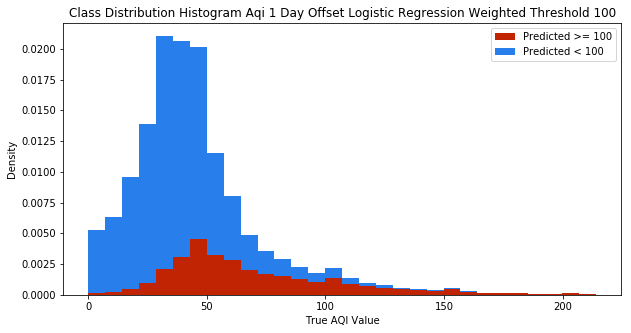

<Figure size 720x360 with 0 Axes>

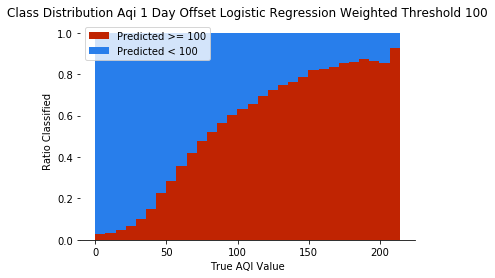

Beginning training fold 1
Training took 66.35 sec
Beginning training fold 2
Training took 74.45 sec
Beginning training fold 3
Training took 75.90 sec
Beginning training fold 4
Training took 59.47 sec
Beginning training fold 5
Training took 76.78 sec
training on whole set for unlabelled samples
Training took 76.75 sec


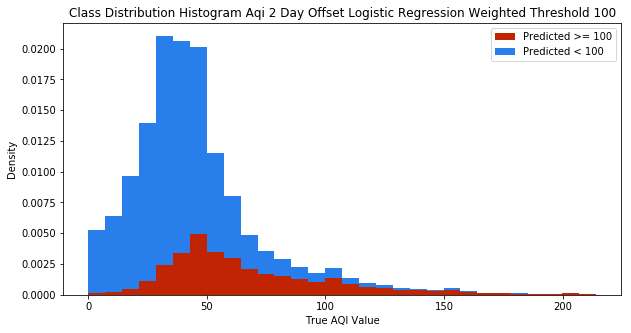

<Figure size 720x360 with 0 Axes>

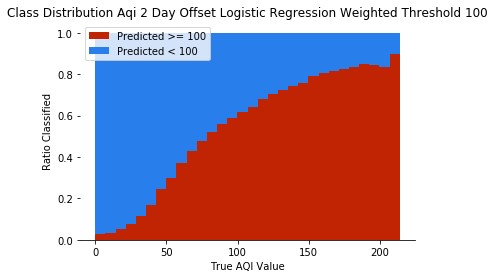

Beginning training fold 1
Training took 72.13 sec
Beginning training fold 2
Training took 91.68 sec
Beginning training fold 3
Training took 78.94 sec
Beginning training fold 4
Training took 77.99 sec
Beginning training fold 5
Training took 78.06 sec
training on whole set for unlabelled samples
Training took 83.63 sec


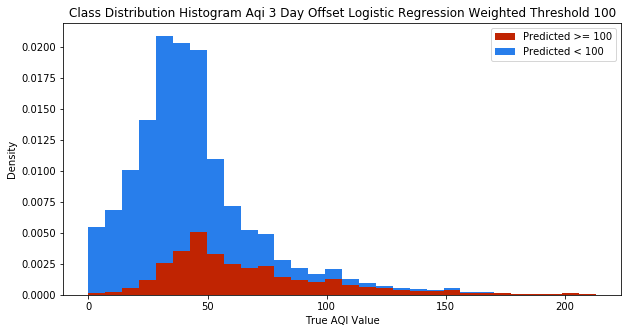

<Figure size 720x360 with 0 Axes>

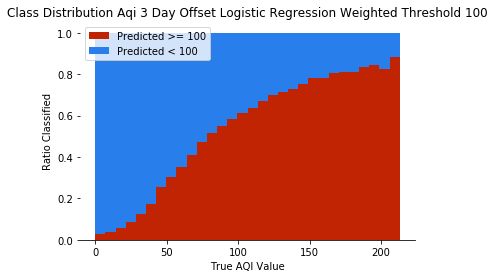

Beginning training fold 1
Training took 70.57 sec
Beginning training fold 2
Training took 86.91 sec
Beginning training fold 3
Training took 84.84 sec
Beginning training fold 4
Training took 86.12 sec
Beginning training fold 5
Training took 82.19 sec
training on whole set for unlabelled samples
Training took 90.59 sec


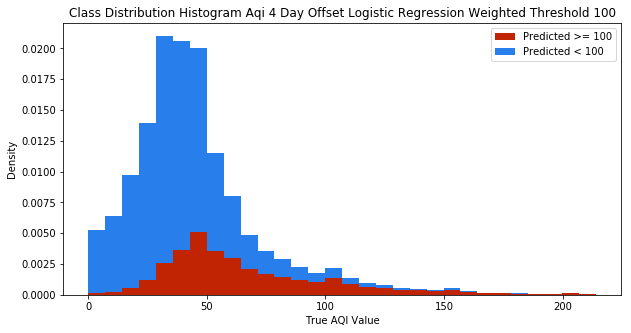

<Figure size 720x360 with 0 Axes>

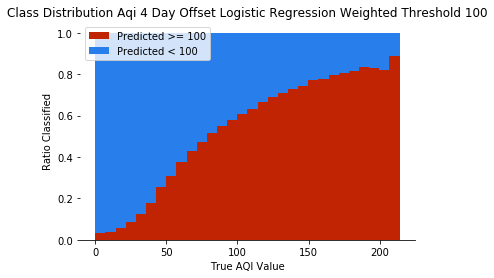

Beginning training fold 1
Training took 67.15 sec
Beginning training fold 2
Training took 81.52 sec
Beginning training fold 3
Training took 90.22 sec
Beginning training fold 4
Training took 87.75 sec
Beginning training fold 5
Training took 70.49 sec
training on whole set for unlabelled samples
Training took 85.20 sec


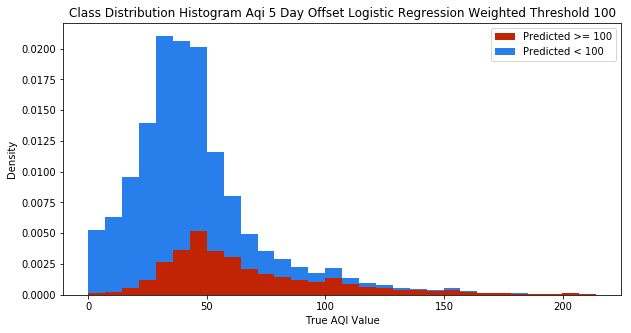

<Figure size 720x360 with 0 Axes>

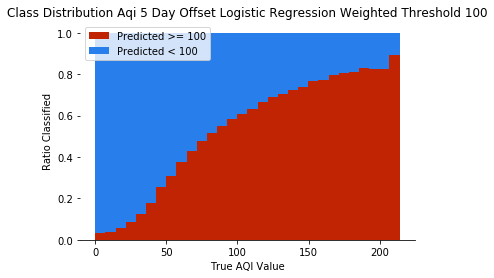

Beginning training fold 1
Training took 69.48 sec
Beginning training fold 2
Training took 82.68 sec
Beginning training fold 3
Training took 66.60 sec
Beginning training fold 4
Training took 75.13 sec
Beginning training fold 5
Training took 80.33 sec
training on whole set for unlabelled samples
Training took 101.58 sec


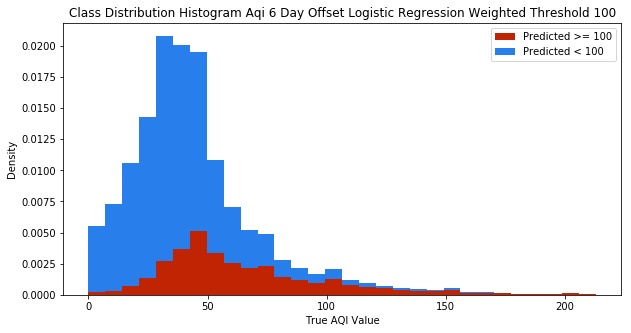

<Figure size 720x360 with 0 Axes>

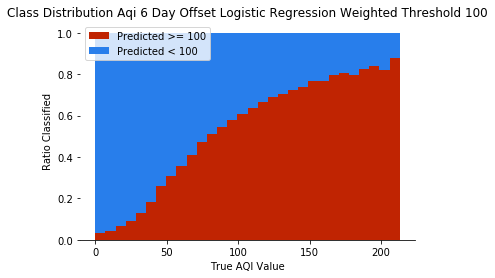

Beginning training fold 1
Training took 62.88 sec
Beginning training fold 2
Training took 75.03 sec
Beginning training fold 3
Training took 87.47 sec
Beginning training fold 4
Training took 83.75 sec
Beginning training fold 5
Training took 88.46 sec
training on whole set for unlabelled samples
Training took 83.72 sec


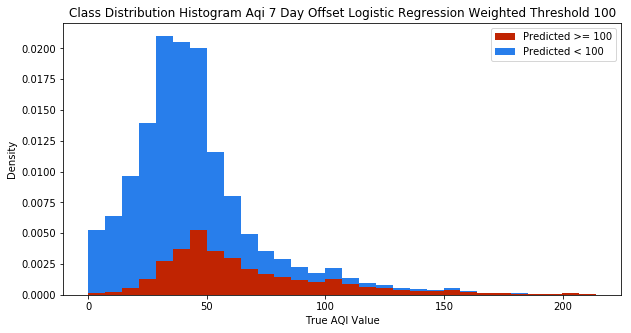

<Figure size 720x360 with 0 Axes>

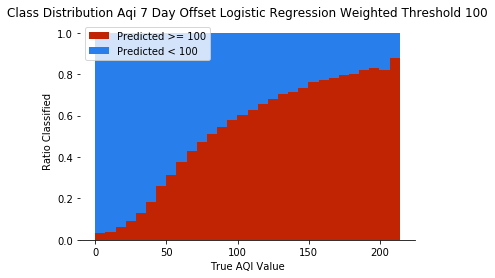

In [11]:
# do for 7 day forcast
labels = [f'AQI_{i}_DAY_OFFSET'for i in range(1,8)]
threshold = 100
clf = linear_model.LogisticRegression(class_weight='balanced')#sklearn.tree.DecisionTreeClassifier(max_depth=5))
model_name = 'Logistic Regression Weighted'

#df where we will save all values
output_df = aqi_df[['COUNTY_CODE', 'STATE_NAME', 'DATE']]
columns = ['label', 'accuracy','f1-score macro', 'precision macro', 'recall macro']
summary_df = pd.DataFrame(np.zeros(shape=(len(labels),len(columns))), columns = columns)

for i,label in enumerate(labels):
    label_pretty = string.capwords(' '.join(label.split('_')))
    #kfold##########################################################################################################
    clf, y_pred, y_pred_unlabelled = build_k_day_classifier(X, aqi_df[label].values,\
                    threshold = threshold, clf = clf)
    #evaluate summary stats#########################################################################################
    y = aqi_df[label].values
    classification_report = sklearn.metrics.classification_report(y[~np.isnan(y)]>=threshold, y_pred, output_dict=True)
    summary_df.iloc[i,:] = [label, classification_report['accuracy'], classification_report['macro avg']['f1-score'],\
                            classification_report['macro avg']['precision'], classification_report['macro avg']['recall']]
    #add labels as column###########################################################################################
    output_df[f'AQI_{i+1}'] = aqi_df[label]
    output_df[f'AQI_{i+1}'][~np.isnan(y)] = y_pred
    output_df[f'AQI_{i+1}'][np.isnan(y)] = y_pred_unlabelled
    #make two plots#################################################################################################
    # do histograms of the classifier results
    num_bins = 30
    plt.figure(figsize=(10,5))
    # remove top .1 percent for outlier issues
    y = aqi_df[label].values
    y = y[~np.isnan(y)]
    mask_remove = trim_percent(y,.05)
    # get two groups
    distributions = [y[y_pred&~mask_remove], y[~y_pred&~mask_remove]]
    # plot
    plt.hist(distributions, bins = num_bins, density=True, histtype='bar', stacked=True,\
             label=[f'Predicted >= {threshold}', f'Predicted < {threshold}'], color=['#C02402', '#287EEB'])
    plt.legend()
    plt.title(f'Class Distribution Histogram {label_pretty} {model_name} Threshold {threshold}')
    plt.xlabel('True AQI Value')
    plt.ylabel('Density')
    plt.savefig(f'analysis_plots/hist1D/histogram_{model_name}_{threshold}_{label}.svg')
    plt.show()
    plt.close()
    
    
    # do ratio of the classifier results
    num_bins = 30
    plt.figure(figsize=(10,5))
    fig, ax = plt.subplots()

    # remove top .1 percent for outlier issues
    y = aqi_df[label].values
    y = y[~np.isnan(y)]
    mask_remove = trim_percent(y,.05)

    # get two groups
    y_min, y_max = np.min(y[~mask_remove]), np.max(y[~mask_remove])
    y_pred_on, y_pred_off = y[y_pred&~mask_remove], y[~y_pred&~mask_remove]
    (y_pred_on_bin,bin_vals), (y_pred_off_bin,_) = np.histogram(y_pred_on, range=(y_min,y_max), bins = num_bins),\
                                        np.histogram(y_pred_off, range=(y_min,y_max), bins = num_bins)
    # normalize to 1
    total = y_pred_on_bin+y_pred_off_bin
    y_pred_on_bin, y_pred_off_bin = y_pred_on_bin/total, y_pred_off_bin/total
    ind = (bin_vals[1:] + bin_vals[:-1])/2

    # plot
    p1 = plt.bar(ind, y_pred_on_bin, width=bin_vals[1]-bin_vals[0], color='#C02402')
    p2 = plt.bar(ind, y_pred_off_bin, bottom=y_pred_on_bin, width=bin_vals[1]-bin_vals[0], color='#287EEB')

    plt.legend((p1[0], p2[0]), (f'Predicted >= {threshold}', f'Predicted < {threshold}'))
    plt.title(f'Class Distribution {label_pretty} {model_name} Threshold {threshold}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlabel('True AQI Value')
    plt.ylabel('Ratio Classified')
    plt.savefig(f'analysis_plots/hist1D/class_distribution_{model_name}_{threshold}_{label}.svg')
    plt.show()

In [12]:
output_df.head()

,COUNTY_CODE,STATE_NAME,DATE,AQI_1,AQI_2,AQI_3,AQI_4,AQI_5,AQI_6,AQI_7
0,15,Alabama,1992-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15,Alabama,1992-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,Alabama,1992-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,Alabama,1992-01-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,Alabama,1992-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
summary_df

,label,accuracy,f1-score macro,precision macro,recall macro
0,AQI_1_DAY_OFFSET,0.803037,0.594838,0.585635,0.762065
1,AQI_2_DAY_OFFSET,0.791161,0.582184,0.578361,0.747455
2,AQI_3_DAY_OFFSET,0.787737,0.574873,0.573740,0.741981
3,AQI_4_DAY_OFFSET,0.784391,0.574837,0.574108,0.737531
4,AQI_5_DAY_OFFSET,0.783289,0.574135,0.573768,0.736229
5,AQI_6_DAY_OFFSET,0.784185,0.569527,0.570547,0.736705
6,AQI_7_DAY_OFFSET,0.780306,0.570828,0.571853,0.731753


In [14]:
output_df.to_csv('datasets/aqi_predictions.csv')
summary_df.to_csv('datasets/aqi_predictions_summary.csv')

In [100]:
# see how well the classification went
# clf, y_train, y_train_pred, y_test, y_test_pred, features, threshold
y = aqi_df[label].values
classification_report = sklearn.metrics.classification_report(y[~np.isnan(y)]>=threshold, y_pred, output_dict=True)
print('test kfold')
print(classification_report)

test kfold
{'False': {'precision': 0.7801039330133843, 'recall': 0.8878639292361103, 'f1-score': 0.8305029837249991, 'support': 4647229}, 'True': {'precision': 0.6368533356376017, 'recall': 0.4400151182133546, 'f1-score': 0.5204444326752151, 'support': 2076965}, 'accuracy': 0.7495326577430693, 'macro avg': {'precision': 0.708478634325493, 'recall': 0.6639395237247325, 'f1-score': 0.6754737082001071, 'support': 6724194}, 'weighted avg': {'precision': 0.7358567746210785, 'recall': 0.7495326577430693, 'f1-score': 0.7347322848901476, 'support': 6724194}}


['AQI_1_DAY_OFFSET',
 0.7495326577430693,
 0.6754737082001071,
 0.708478634325493,
 0.6639395237247325]

In [ ]:
# do histograms of the classifier results
num_bins = 30
plt.figure(figsize=(10,5))

# remove top .1 percent for outlier issues
y = aqi_df[label].values
y = y[~np.isnan(y)]
mask_remove = trim_percent(y,.05)
# get two groups
distributions = [y[y_pred&~mask_remove], y[~y_pred&~mask_remove]]
# plot
plt.hist(distributions, bins = num_bins, density=True, histtype='bar', stacked=True,\
         label=[f'Predicted >= {threshold}', f'Predicted < {threshold}'], color=['#C02402', '#287EEB'])
plt.legend()
plt.title(f'Class Distribution Histogram {label_pretty} {model_name} Threshold {threshold}')
plt.xlabel('True AQI Value')
plt.ylabel('Density')
plt.savefig(f'analysis_plots/hist1D/histogram_{model_name}_{threshold}_{label}.svg')
plt.show()
plt.close()

In [ ]:
# do histograms of the classifier results
num_bins = 30
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()

# remove top .1 percent for outlier issues
y = aqi_df[label].values
y = y[~np.isnan(y)]
mask_remove = trim_percent(y,.05)

# get two groups
y_min, y_max = np.min(y[~mask_remove]), np.max(y[~mask_remove])
y_pred_on, y_pred_off = y[y_pred&~mask_remove], y[~y_pred&~mask_remove]
(y_pred_on_bin,bin_vals), (y_pred_off_bin,_) = np.histogram(y_pred_on, range=(y_min,y_max), bins = num_bins),\
                                    np.histogram(y_pred_off, range=(y_min,y_max), bins = num_bins)
# normalize to 1
total = y_pred_on_bin+y_pred_off_bin
y_pred_on_bin, y_pred_off_bin = y_pred_on_bin/total, y_pred_off_bin/total
ind = (bin_vals[1:] + bin_vals[:-1])/2

# plot
p1 = plt.bar(ind, y_pred_on_bin, width=bin_vals[1]-bin_vals[0], color='#C02402')
p2 = plt.bar(ind, y_pred_off_bin, bottom=y_pred_on_bin, width=bin_vals[1]-bin_vals[0], color='#287EEB')

plt.legend((p1[0], p2[0]), (f'Predicted >= {threshold}', f'Predicted < {threshold}'))
plt.title(f'Class Distribution {label_pretty} {model_name} Threshold {threshold}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('True AQI Value')
plt.ylabel('Ratio Classified')
plt.savefig(f'analysis_plots/hist1D/class_distribution_{model_name}_{threshold}_{label}.svg')
plt.show()